# Backtesting

This notebook generates plots for for backtesting. It requires that the script `run_backtesting.sh` has been run prior to execution.

In [1]:
# imports
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf
from pyrocov.util import pretty_print, pearson_correlation
import seaborn as sns

In [2]:
# configure logging
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

In [3]:
# This line can be used to modify logging as required
logging.getLogger().setLevel(logging.INFO)

In [4]:
# set matplotlib params
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [5]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 2161248 samples


In [6]:
columns.keys()

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])

In [8]:
# print some example values
for k in columns.keys():
    print(k, columns[k][0:2])

lineage ['B.1', 'B.1']
virus_name ['hCoV-19/Australia/NT12/2020', 'hCoV-19/Australia/NT13/2020']
accession_id ['EPI_ISL_426900', 'EPI_ISL_426901']
collection_date ['2020-03-25', '2020-03-25']
location ['Oceania / Australia / Northern Territory', 'Oceania / Australia / Northern Territory']
add_location ['', '']
day [115, 115]


## Load trained models

In [9]:
fits = torch.load("results/mutrans.backtesting.pt", map_location="cpu")

In [10]:
# print info on available models and what the keys are
if False:
    for key in fits:
        print(key)
    first_key = list(fits.keys())[0]
    fits[first_key].keys()

In [11]:
# Print the shape of the weekly strains in each fit
if False:
    for fit in fits.values():
        print(fit["weekly_strains_shape"])

In [12]:
# This is really just the second fit
#selected_fit = list(fits.values())[1]
#pretty_print(selected_fit, max_items=40)

Scale `coef` by 1/100 in all results.

In [13]:
ALREADY_SCALED = set()

def scale_tensors(x, names={"coef"}, scale=0.01, prefix="", verbose=True):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k in names:
                if verbose:
                    print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, names, scale, f"{prefix}.{k}", verbose=verbose)
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits, verbose=False)

# Forecasting

In [14]:
import importlib
from pyrocov import mutrans_helpers

In [15]:
# customize logging
if False:
    logging.getLogger().setLevel(logging.ERROR)

## Day 542: Last available

In [16]:
if False:
    logging.getLogger().setLevel(logging.INFO)

Max days of model: 542


   136257 Generating output tensor
   136259 --- Processing query 0


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


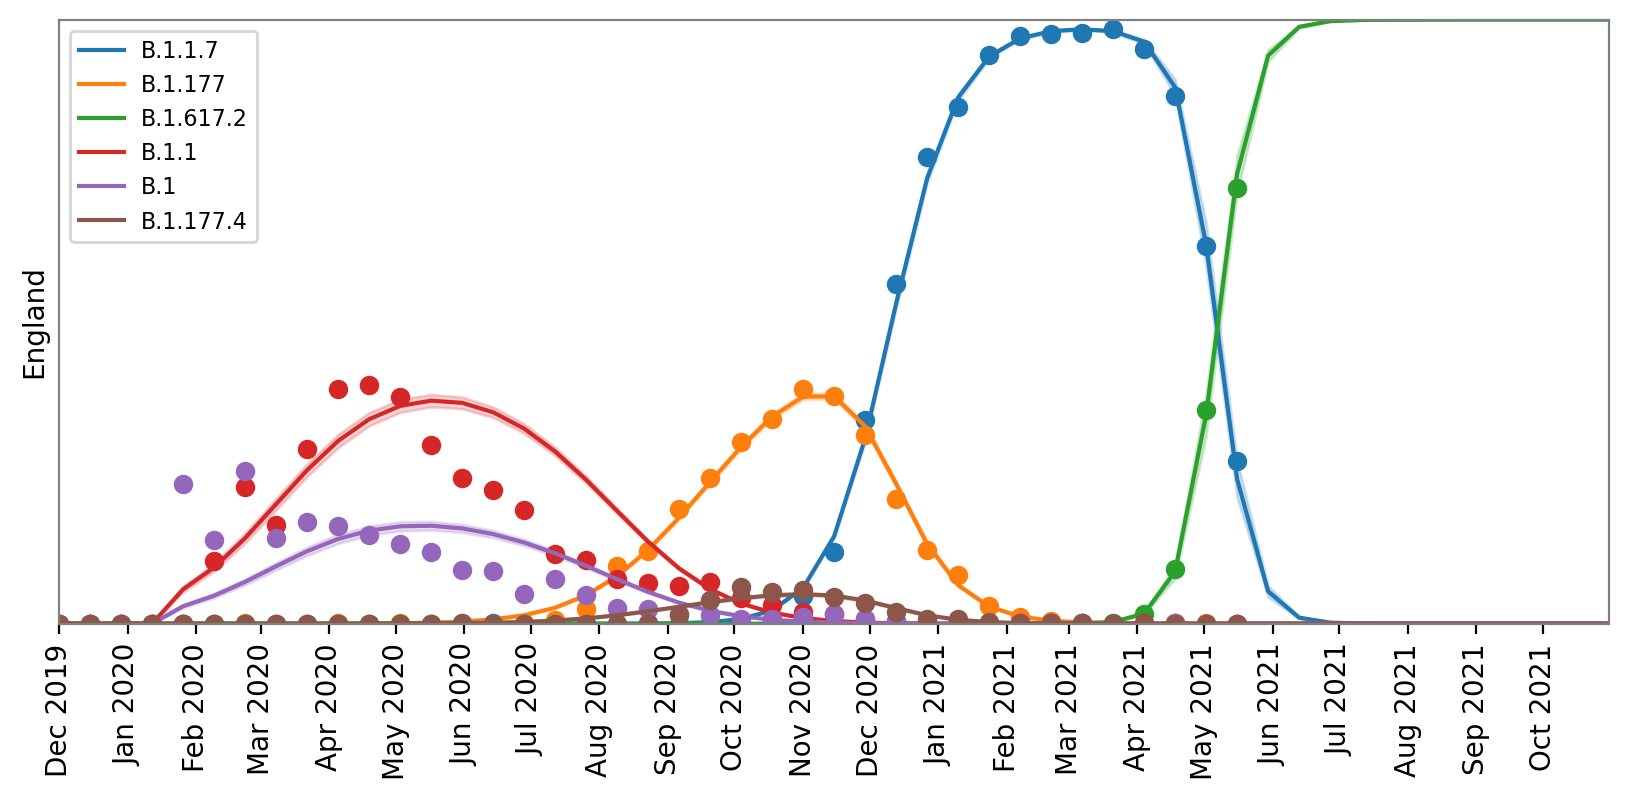

In [17]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    filename="paper/forecasts/forecast_day_542.png"
)

## Day 346:  B.1.1.7 in UK

   142779 Generating output tensor
   142780 --- Processing query 0


Max days of model: 346
sel_forecast shape torch.Size([37, 1281])
sel_forecast_lb shape torch.Size([37, 1281])


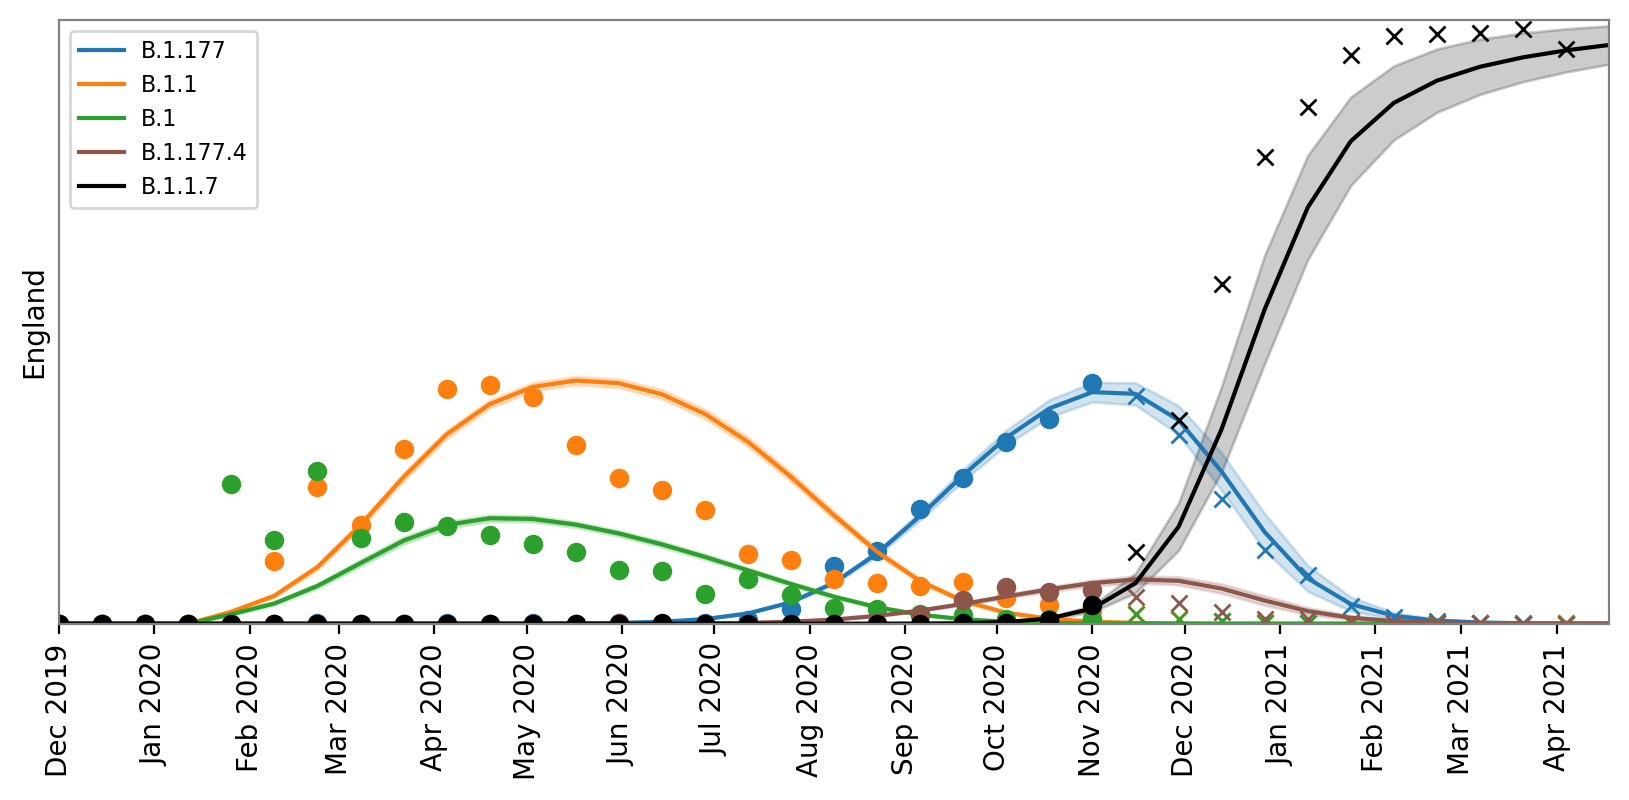

In [18]:
importlib.reload(mutrans_helpers)

i = 14
key, fit_d346 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d346, 
    strains_to_show=strains_from_manuscript_figure,queries=['England'],
    future_fit=latest_fit,
    num_strains=2000,
    filename="paper/forecasts/forecast_day_346.png"
)

In [19]:
importlib.reload(mutrans_helpers)

<module 'pyrocov.mutrans_helpers' from '/home/nbarkas/pyro-cov/pyro-cov/pyrocov/mutrans_helpers.py'>

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
q = {"England": ['B.1','B.1.1.7','B.1.177','B.1.177.4']}

fit_eval_d346 = mutrans_helpers.evaluate_fit_forecast(fit_d346, latest_fit)

In [ ]:
# TODO: make multiple of these for all the models and add to preprint

In [ ]:
plt.plot(fit_eval_d346['mae'])
plt.ylim(0, None)
plt.ylabel("KL divergence")
plt.xlabel("Time into future");

In [ ]:
plt.plot(fit_eval_d346['kl'])
plt.ylim(0, None)
plt.ylabel("KL divergence")
plt.xlabel("Time into future");

In [ ]:
plt.plot(-fit_eval_d346['log_likelihood'], "r-");
plt.plot(fit_eval_d346['entropy'], "k--");
plt.plot(fit_eval_d346['kl'], "g--");

In [ ]:
plt.plot(fit_eval_d346['log_likelihood'].exp(), "r-");
plt.plot((-fit_eval_d346['entropy']).exp(), "k--");

# Day 234: B.1.617.2 in UK

In [ ]:
importlib.reload(mutrans_helpers)

In [ ]:
i = 26
key, fit_d514 = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1',
                                 'B.1.1','B.1','B.1.427','B.1.2','B.1.177.4']

matplotlib.rcParams['figure.figsize'] = [10, 4]
mutrans_helpers.plot_fit_forecasts(
    fit=fit_d514, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['England'],
    future_fit=latest_fit,
    filename='paper/forecasts/forecast_day_514.png',
    forecast_periods_plot=2,
)

In [ ]:
mutrans_helpers.evaluate_fit_forecast(fit_d514, latest_fit)

In [ ]:
type(fits)

In [ ]:
fits.values()

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
#mutrans_helpers.evaluate_fit_forecast(fit_d514, latest_fit)

In [ ]:
x = np.linspace(0.0, 1.0, len(evaluations)+1)

In [ ]:
cmap = matplotlib.cm.get_cmap('rainbow')

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [ ]:
nValues = [k[8] for k,v in evaluations]
nValues = np.array(nValues)

In [ ]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet

In [ ]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    kl = v['kl']
    plt.plot(kl, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('KL Divergence (nats)')

plt.show()

## Alternative Representation

In [ ]:
start_days = []
forecast_days = []
kl = []

for i,(k,v) in enumerate(evaluations):
    start_days_c = k[8]
    kl_vals = v['kl']
    for j, p in enumerate(kl_vals):
        start_days.append(start_days_c)
        forecast_days.append(j)
        kl.append(p.numpy().item())

df1 = pd.DataFrame({"start":start_days,"forecast":forecast_days,"kl":kl}).pivot(index='start', columns='forecast')

In [ ]:
# generate heatmap
sns.heatmap(df2.T.to_numpy())

In [ ]:
## MAE

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['mae']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Mean Absolute Error')

plt.show()

In [ ]:
evaluations = [(k,mutrans_helpers.evaluate_fit_forecast(f, latest_fit)) for k,f in fits.items()]

In [ ]:
# Wasserstein

for i,(k,v) in enumerate(evaluations):
    model_days = k[8]
    mae = v['wasserstein']
    plt.plot(mae, color=colormap(normalize(model_days)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nValues)
plt.colorbar(scalarmappaple, label='Max training day of model')

plt.xlim(0, 11)

plt.xticks([0, 2, 4, 6, 8, 10], labels=["0", "4", "8", "12", "16", "20"])

plt.xlabel('Forecasted weeks ahead')
plt.ylabel('Wasserstein')

plt.show()

## Look at USA California

In [65]:
logging.getLogger().setLevel(logging.DEBUG)

In [112]:
fc0 = mutrans_helpers.generate_forecast(latest_fit, ['USA / California'])

In [113]:
fc0.keys()

dict_keys(['queries', 'date_range', 'strain_ids', 'predicted', 'location_id', 'weekly_cases', 'weekly_strains', 'lineage_id_inv', 'weekly_cases_future', 'weekly_strains_future'])

In [93]:
fc0['predicted'].shape

torch.Size([3, 51, 1069, 1281])

In [98]:
len(fc0['location_id'])

1069

In [99]:
len(fc0['strain_ids'])

1281

In [103]:
fc0['strain_ids']

tensor([998, 518, 993,  ..., 499, 498, 496])

In [107]:
len(fc0['lineage_id_inv'])

1281

In [108]:
fc0['lineage_id_inv'][0:3]

['A', 'A.1', 'A.11']

In [109]:
fc0['lineage_id_inv'].index('AY.2')

1190

In [111]:
fc0['predicted'][1,-3,18,1190]

tensor(271.2918)

In [127]:
mutrans_helpers.generate_strain_color_map_dict(['1','asdf'])

{'1': 'C0', 'asdf': 'C1'}

  4713113 key list length 29
  4713114 key is ('coef_scale=0.5', 'custom', 10001, 0.05, 0.1, 10.0, 200, 12, 542, ())
  4713114 Entering plot_fit_forecast()
  4713115 Generating forecast...


Max days of model: 542


  4713400 Getting forecast values...
  4713401 date_range shape (51,)
  4713401 predicted shape torch.Size([3, 51, 1069, 1281])
  4713402 queries length 1
  4713402 weekly_cases shape (39, 1069)
  4713403 weekly_strains shape (39, 1069, 1281)
  4713404 Generating output tensor
  4713404 Output predicted tensor shape: [1, 3, 51, 1281]
  4713405 Output observed tensor shape: [1, 39, 1281]
  4713406 --- Processing query 0
  4713407 ids in query: tensor([18])
  4713407 ids length:1
  4713408 pred shape (3, 51, 1281)
  4713409 obs shape (39, 1281)
  4713410 output_predicted shape: (1, 3, 51, 1281)
  4713410 output_observed shape: (1, 39, 1281)
  4713410 k: 0
  4713412 dates length: 51
  4713942 ** Plotting ['USA / California']
  4713944 Drawing strain 998, B.1.429
  4713948 Drawing strain 518, B.1.1.7
  4713958 Drawing strain 250, P.1
  4713982 Drawing strain 1188, B.1.617.2
  4714141 Drawing strain 623, B.1.177


sel_forecast shape torch.Size([51, 1281])
sel_forecast_lb shape torch.Size([51, 1281])


  4714269 Drawing strain 1190, AY.2


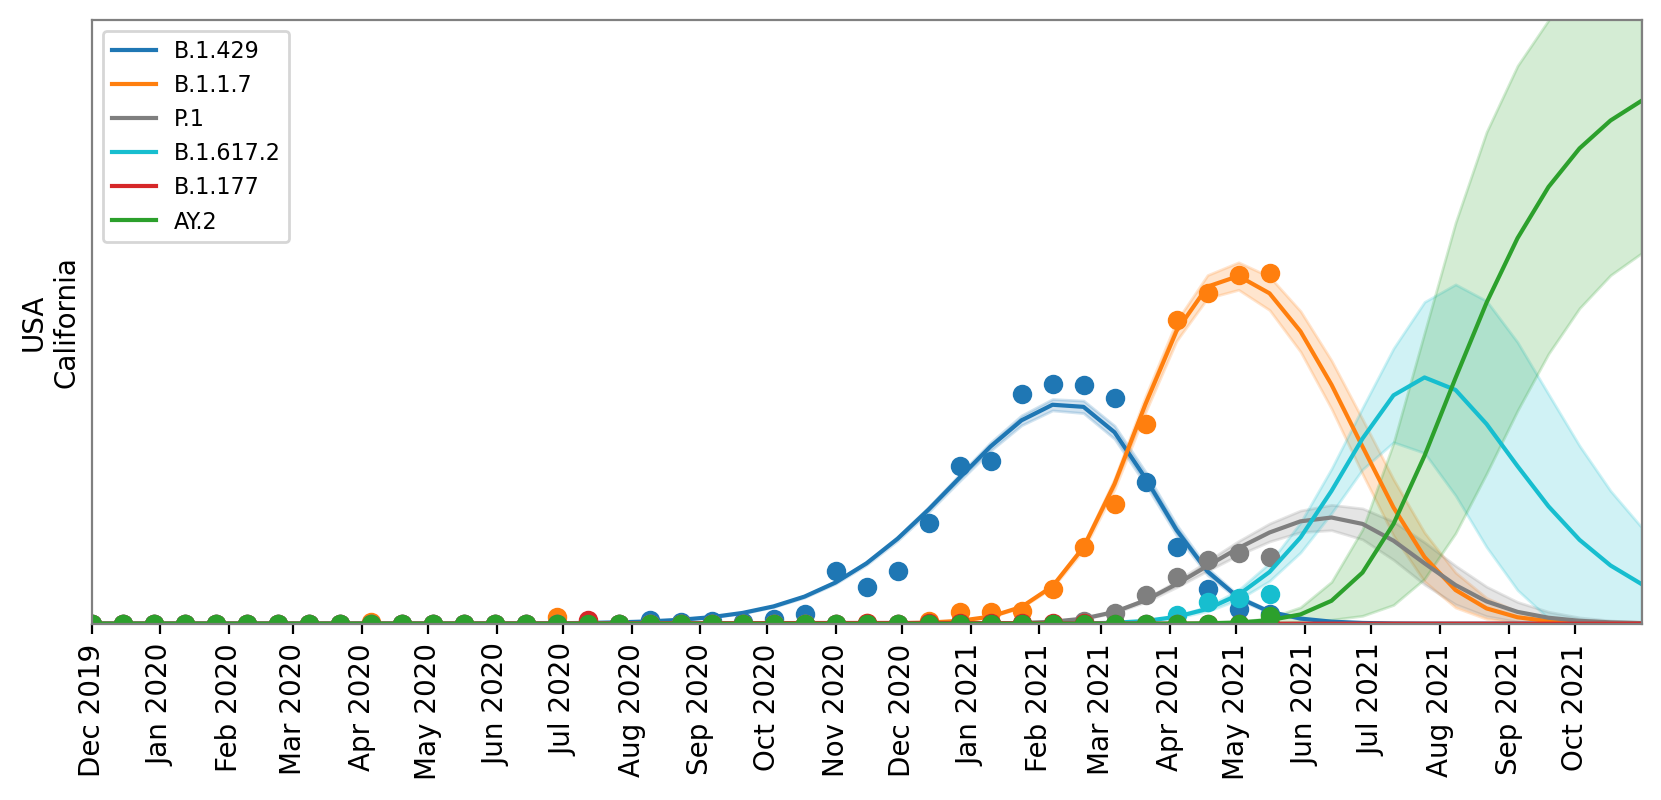

In [138]:
importlib.reload(mutrans_helpers)

i = len(fits) - 1
key, latest_fit = mutrans_helpers.get_fit_by_index(fits, i)
print(f"Max days of model: {key[8]}")

strains_from_manuscript_figure = ['AY.2','B.1.1.7','B.1.617.2','B.1.177','B.1.429','P.1']

matplotlib.rcParams['figure.figsize'] = [10, 4]
z = mutrans_helpers.plot_fit_forecasts(
    fit=latest_fit, 
    strains_to_show=strains_from_manuscript_figure,
    queries=['USA / California'],
)

In [119]:
z['strain_ids']

tensor([998, 518, 993,  ..., 499, 498, 496])

In [117]:
z['predicted'].shape

torch.Size([1, 3, 51, 1281])

In [116]:
z.keys()

dict_keys(['queries', 'predicted', 'observed', 'date_range', 'strain_ids', 'lineage_id_inv', 'observed_future'])

In [61]:
# find the top strain in California a few periods before end of forecast

In [39]:
for k,v in latest_fit['location_id'].items():
    if k.find('California') > 0:
        print(k,v)

North America / USA / California 18
North America / Mexico / Baja California Sur 502
North America / Mexico / Baja California 506


In [44]:
CA_Aug = latest_fit['mean']['probs'][-3,18].clone()

In [48]:
CA_Aug.argmax()

tensor(1190)

In [49]:
CA_Aug[1190]

tensor(0.7869)

In [52]:
latest_fit['lineage_id_inv'][1190]

'AY.2'